<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mdn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mdn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Mixture Density Network

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cpu].


### Dataset

x_train:(5000, 1), y_train:(5000, 2)


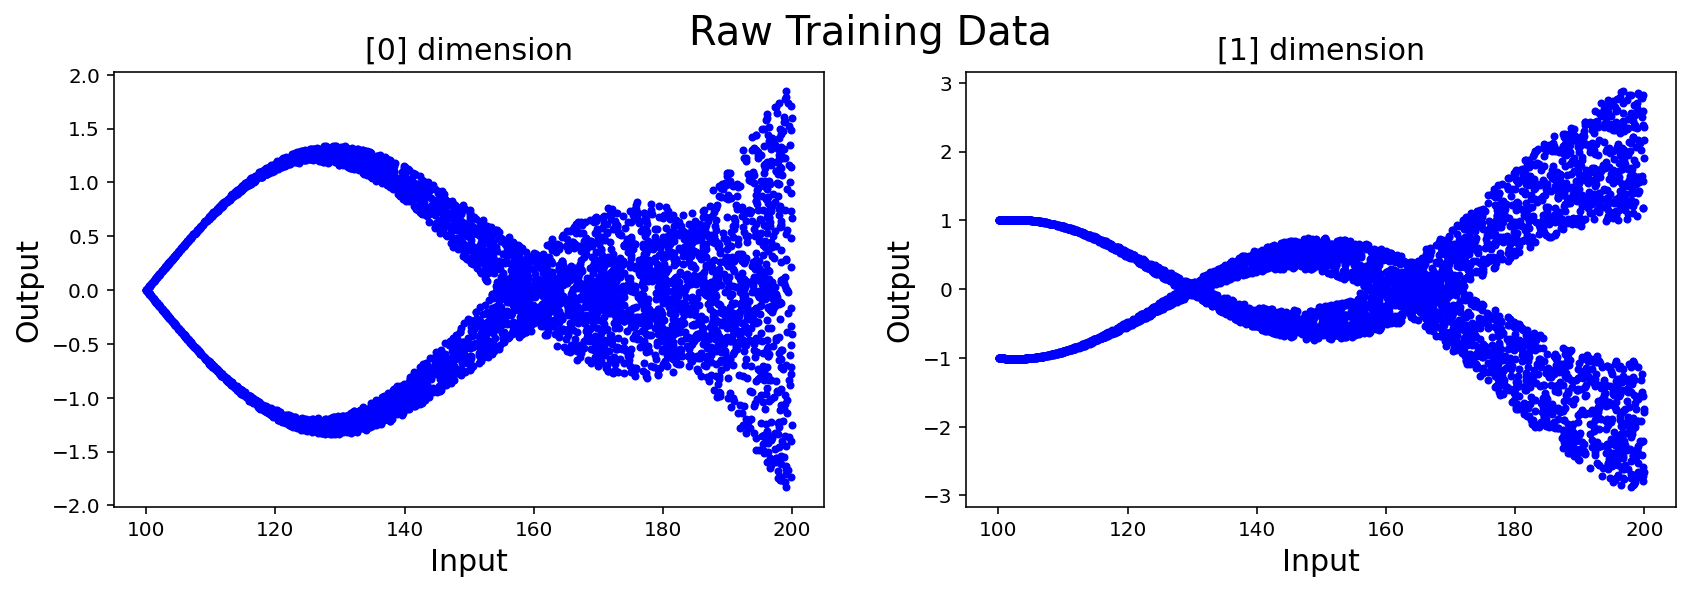

Done.


In [2]:
def get_mdn_data(n_train=1000,xmin=0,xmax=1,ymin=-1,ymax=1,freq=1,noise_rate=1):
    np.random.seed(seed=0)
    n_half   = n_train // 2
    x_train  = xmin + (xmax-xmin)*np.random.rand(n_half,1) # [N//2 x 1]
    x_rates  = (x_train-xmin)/(xmax-xmin) # [N//2 x 1]
    sin_temp = ymin + (ymax-ymin)*np.sin(2*np.pi*freq*x_rates) # [N//2 x 1]
    cos_temp = ymin + (ymax-ymin)*np.cos(2*np.pi*freq*x_rates) # [N//2 x 1]
    y_train  = np.concatenate((sin_temp+1*(ymax-ymin)*x_rates,
                               cos_temp+1*(ymax-ymin)*x_rates),axis=1) # [N//2 x 2]
    x_train = np.concatenate((x_train,x_train),axis=0) # [N x 1]
    y_train = np.concatenate((y_train,-y_train),axis=0) # [N x 2]
    # Add noise
    x_rates = (x_train-xmin)/(xmax-xmin) # [N x 1]
    noise   = noise_rate * (ymax-ymin) * (2*np.random.rand(n_train,2)-1) * ((x_rates)**2) # [N x 2]
    y_train = y_train + noise
    return x_train,y_train

# Training data
n_train = 5000
x_train,y_train = get_mdn_data(n_train=n_train,xmin=100,xmax=200,ymin=0,ymax=1,freq=1,noise_rate=1)
print ("x_train:%s, y_train:%s"%(x_train.shape,y_train.shape))

# Plot
fig = plt.figure(figsize=(14,4))
for d_idx in range(y_train.shape[1]):
    plt.subplot(1,y_train.shape[1],d_idx+1)
    plt.plot(x_train,y_train[:,d_idx],'b.')
    plt.title('[%d] dimension'%(d_idx),fontsize=15)
    plt.xlabel('Input',fontsize=15); plt.ylabel('Output',fontsize=15)
fig.suptitle('Raw Training Data',fontsize=20)
plt.show()
print ("Done.")

### Normalizer

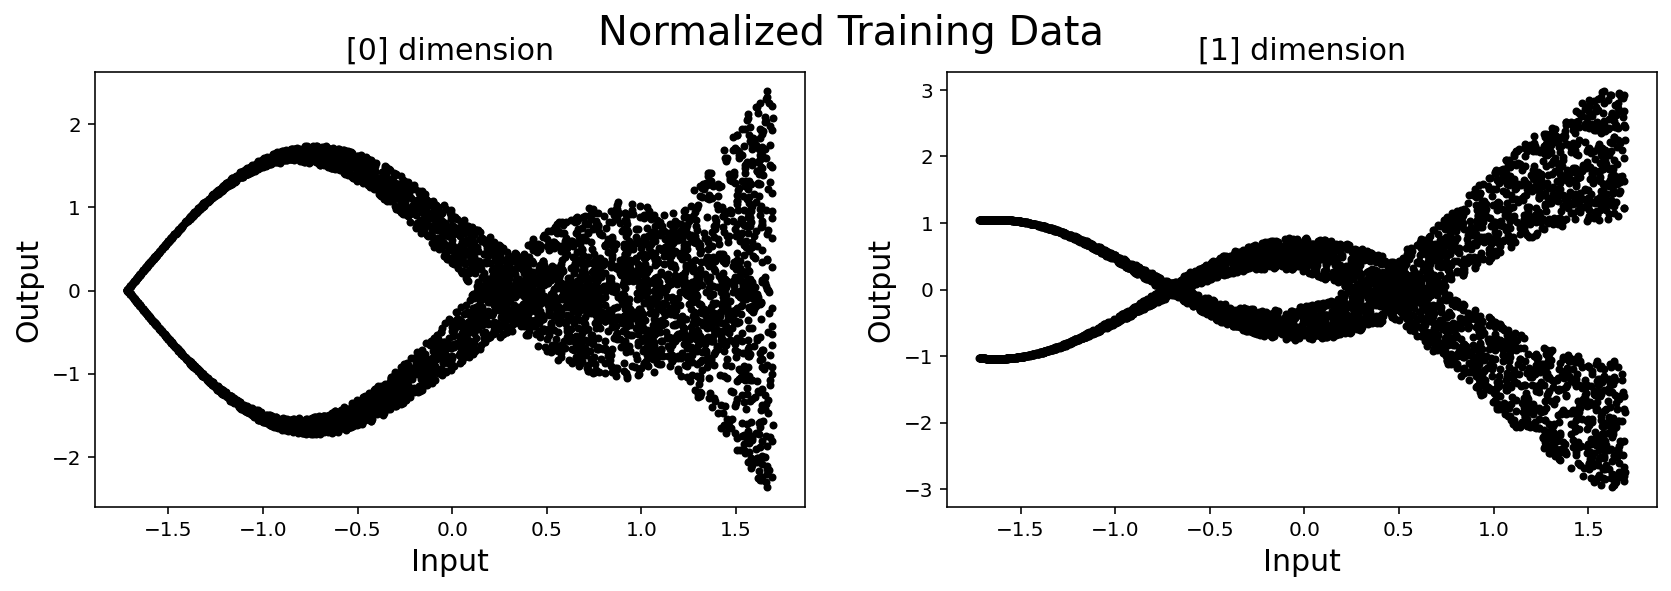

Done.


In [3]:
class NormalizerClass(object):
    def __init__(self,raw_data,eps=1e-8):
        self.raw_data = raw_data
        self.eps = eps
        self.mean = np.mean(self.raw_data,axis=0)
        self.std = np.std(self.raw_data,axis=0)
        self.mean = self.mean[np.newaxis,:]
        self.std = self.std[np.newaxis,:]
        self.nzd_data = self.get_nzd_val(self.raw_data)
        self.org_data = self.get_org_val(self.nzd_data)
    
    def get_nzd_val(self,raw_val):
        n = raw_val.shape[0]
        nzd_val = (raw_val - self.mean.repeat(n,axis=0)) / (self.std+self.eps).repeat(n,axis=0)
        return nzd_val

    def get_org_val(self,nzd_val):
        n = nzd_val.shape[0]
        org_val = nzd_val*(self.std+self.eps).repeat(n,axis=0) + self.mean.repeat(n,axis=0)
        return org_val

def scale_vec(v):
    v_min, v_max = np.min(v), np.max(v)
    return (v - v_min) / (v_max - v_min)
    
# Normalize training data
nzr_x = NormalizerClass(raw_data=x_train)
nzr_y = NormalizerClass(raw_data=y_train)
x_train_nzd,y_train_nzd = nzr_x.nzd_data,nzr_y.nzd_data

# Plot
fig = plt.figure(figsize=(14,4))
for d_idx in range(y_train_nzd.shape[1]):
    plt.subplot(1,y_train_nzd.shape[1],d_idx+1)
    plt.plot(x_train_nzd,y_train_nzd[:,d_idx],'k.')
    plt.title('[%d] dimension'%(d_idx),fontsize=15)
    plt.xlabel('Input',fontsize=15); plt.ylabel('Output',fontsize=15)
fig.suptitle('Normalized Training Data',fontsize=20)
plt.show()
print ("Done.")

### Define MDN model
- $f(x) = \frac{1}{\sqrt{2\pi}} \frac{1}{\sigma} e^{-0.5(\frac{x-\mu}{\sigma})^2} $

In [4]:
import math
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

def gmm_forward(pi,mu,sigma,data):
    """
    pi: [N x K]
    mu: [N x K x D]
    sigma: [N x K x D]
    data: [N x D]
    """
    data_usq = torch.unsqueeze(data,1) # [N x 1 x D]
    data_exp = data_usq.expand_as(sigma) # [N x K x D]
    probs = ONEOVERSQRT2PI * torch.exp(-0.5 * ((data_exp-mu)/sigma)**2) / sigma # [N x K x D]
    probs_prod = torch.prod(probs,2) # [N x K]
    prob = torch.sum(probs_prod*pi,dim=1) # [N]
    nll = -torch.log(prob) # [N] 
    out = {'data_usq':data_usq,'data_exp':data_exp,
           'probs':probs,'probs_prod':probs_prod,'prob':prob,'nll':nll}
    return out

def gmm_sample(pi,mu,sigma):
    """
    pi: [N x K]
    mu: [N x K x D]
    sigma: [N x K x D]
    """
    categorical = TD.Categorical(pi)
    mixture_list = list(categorical.sample().data)
    _N,_D = sigma.size(0),sigma.size(2)
    eps = Variable(torch.empty(_N,_D).normal_()).to(device) # [N x D]
    sample = torch.empty_like(eps) # [N x D]
    for i_idx, mixture_idx in enumerate(mixture_list):
        mu_i,sigma_i = mu[i_idx,mixture_idx],sigma[i_idx,mixture_idx]
        sample[i_idx] = eps[i_idx].mul(sigma_i).add(mu_i)
    return sample # [N x D]

def get_exp_var(pi, mu, sigma):
    # Compute Epistemic Uncertainty
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    mu_avg = torch.sum(torch.mul(pi_exp,mu),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_exp = mu_avg.expand_as(mu) # [N x K x D]
    mu_diff_sq = torch.square(mu-mu_exp) # [N x K x D]
    epis_unct = torch.sum(torch.mul(pi_exp,mu_diff_sq), dim=1)  # [N x D]

    # Compute Aleatoric Uncertainty
    alea_unct = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    return epis_unct,alea_unct

class LinActv(nn.Module):
    def __init__(self,in_dim,out_dim,actv=nn.Tanh()):
        super(LinActv,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.actv = actv
        self.fc = nn.Sequential(
            OrderedDict([
                 ('lin',nn.Linear(self.in_dim,self.out_dim)),
                 ('actv',self.actv)
                ])
            )
    def forward(self,x):
        return self.fc(x)

class MixturesOfGaussianLayer(nn.Module):
    def __init__(self,in_dim,y_dim,k,sig_max=None):
        super(MixturesOfGaussianLayer,self).__init__()
        self.in_dim = in_dim
        self.y_dim = y_dim
        self.k = k
        self.sig_max = sig_max

        self.fc_pi = nn.Linear(self.in_dim,self.k)
        self.fc_mu = nn.Linear(self.in_dim,self.k*self.y_dim)
        self.fc_sigma = nn.Linear(self.in_dim,self.k*self.y_dim)

    def forward(self,x):
        pi_logit = self.fc_pi(x) # [N x K]
        pi = torch.softmax(pi_logit,1) # [N x K]
        mu = self.fc_mu(x) # [N x KD]
        mu = torch.reshape(mu,(-1,self.k,self.y_dim)) # [N x K x D]
        sigma = self.fc_sigma(x) # [N x KD]
        sigma = torch.reshape(sigma,(-1,self.k,self.y_dim)) # [N x K x D]
        if self.sig_max is None:
            sigma = torch.exp(sigma) # [N x K x D]
        else:
            sigma = self.sig_max * torch.sigmoid(sigma) # [N x K x D]
        return pi,mu,sigma

class MixtureDensityNetwork(nn.Module):
    def __init__(self,name='mdn',x_dim=1,y_dim=2,k=5,h_dims=[32,32],actv=nn.Tanh(),sig_max=1,
                 mu_min=-3.0,mu_max=+3.0):
        super(MixtureDensityNetwork,self).__init__()
        self.name = name
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.k = k
        self.h_dims = h_dims
        self.actv = actv
        self.sig_max = sig_max
        self.mu_min = mu_min
        self.mu_max = mu_max
        self.build_model()

    def build_model(self):
        self.layers = nn.ModuleList()
        in_dim = self.x_dim
        for h_dim in self.h_dims:
            hidden_layer = LinActv(in_dim=in_dim,out_dim=h_dim,actv=self.actv)
            self.layers.append(hidden_layer)
            in_dim = h_dim
        # Final GMM
        mog = MixturesOfGaussianLayer(in_dim,self.y_dim,self.k,sig_max=self.sig_max)
        self.layers.append(mog)

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        """
        Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        """
        self.layers[-1].fc_mu.bias.data.uniform_(self.mu_min,self.mu_max)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x  # [D,3,N,k]

# Demo run of 'gmm_forward' and 'gmm_sample'
N,K,D = 3,5,2
pi_torch    = torch.softmax(torch.rand(N,K).to(device),1) # [N x K]
mu_torch    = torch.rand(N,K,D).to(device) # [N x K x D]
sigma_torch = torch.rand(N,K,D).to(device) # [N x K x D]
data_torch  = torch.rand(N,D).to(device) # [N x D]
out         = gmm_forward(pi_torch,mu_torch,sigma_torch,data_torch)
sample      = gmm_sample(pi_torch,mu_torch,sigma_torch)

# Check dimensions of 'gmm_forward' and 'gmm_sample'
def sh(_x): return str(_x.shape)[11:-1] 
print ("N:[%d], K:[%d], D:[%d]"%(N,K,D))
print ("pi_torch:%s"%(sh(pi_torch)))
print ("mu_torch:%s"%(sh(mu_torch)))
print ("sigma_torch:%s"%(sh(sigma_torch)))
print ("data_torch:%s"%(sh(data_torch)))
print ()
print ("data_usq:%s"%(sh(out['data_usq'])))
print ("data_exp:%s"%(sh(out['data_exp'])))
print ("probs:%s"%(sh(out['probs'])))
print ("probs_prod:%s"%(sh(out['probs_prod'])))
print ("prob:%s"%(sh(out['prob'])))
print ("nll:%s"%(sh(out['nll'])))
print ()
print ("sample:%s"%(sh(sample)))

N:[3], K:[5], D:[2]
pi_torch:[3, 5]
mu_torch:[3, 5, 2]
sigma_torch:[3, 5, 2]
data_torch:[3, 2]

data_usq:[3, 1, 2]
data_exp:[3, 5, 2]
probs:[3, 5, 2]
probs_prod:[3, 5]
prob:[3]
nll:[3]

sample:[3, 2]


In [5]:
# Demo run of  Mixture Density Network 
Q = 8 # input dimension 
MDN = MixtureDensityNetwork(
    name='mdn',x_dim=Q,y_dim=D,k=K,h_dims=[32,32],actv=nn.Tanh(),sig_max=1,mu_min=-3.0,mu_max=+3.0
)
MDN.init_param()
x_torch = torch.rand(N,Q)
pi_torch,mu_torch,sigma_torch = MDN.forward(x_torch)
# Check dimensions of 'Mixture Density Network'
print ("N:[%d], K:[%d], Q:[%d], D:[%d]"%(N,K,Q,D))
print ("input:%s"%(sh(x_torch)))
print ("pi_torch:%s"%(sh(pi_torch)))
print ("mu_torch:%s"%(sh(mu_torch)))
print ("mu_torch:\n",mu_torch) # <= results of heuristics 
print ("sigma_torch:%s"%(sh(sigma_torch)))

N:[3], K:[5], Q:[8], D:[2]
input:[3, 8]
pi_torch:[3, 5]
mu_torch:[3, 5, 2]
mu_torch:
 tensor([[[-1.0864, -1.5404],
         [ 1.3425, -2.7207],
         [-1.7925,  1.8489],
         [ 1.2956, -1.4702],
         [ 2.3024, -0.7146]],

        [[-0.4134, -1.0490],
         [ 1.3612, -2.4727],
         [-2.6698,  1.9054],
         [ 1.8630, -1.5635],
         [ 2.6591,  0.0844]],

        [[-1.8024, -1.1661],
         [ 0.8808, -1.8667],
         [-1.2438,  1.0248],
         [ 0.5280, -1.6480],
         [ 2.1899, -0.1551]]], grad_fn=<ViewBackward>)
sigma_torch:[3, 5, 2]


### Train

In [6]:
# Model
MDN = MixtureDensityNetwork(
    name='mdn',x_dim=1,y_dim=2,k=10,h_dims=[64,64],actv=nn.Tanh(),sig_max=1,
    mu_min=-3.0,mu_max=+3.0).to(device)
# Optimizers
LEARNING_RATE = 1e-3
optm = optim.Adam(MDN.parameters(),lr=LEARNING_RATE)
print ("Done.")

Done.


In [7]:
def debug_plot(MDN,x_torch,y_torch,x_train_nzd,y_train_nzd):
    # Forward path 
    x_torch_sorted,_ = torch.sort(x_torch.view(-1),descending=False)
    x_torch_sorted = x_torch_sorted.view(-1,1)
    x_sorted_numpy = x_torch_sorted.detach().cpu().numpy()
    pi_torch,mu_torch,sigma_torch = MDN.forward(x_torch_sorted)
    pi_numpy = pi_torch.detach().cpu().numpy() # [N x K]
    mu_numpy = mu_torch.detach().cpu().numpy() # [N x K x D]
    sigma_numpy = sigma_torch.detach().cpu().numpy() # [N x K x D]
    sample_torch = gmm_sample(pi_torch,mu_torch,sigma_torch)
    sample_numpy = sample_torch.detach().cpu().numpy() # [N x D]

    # Uncertainties
    epis_unct,alea_unct = get_exp_var(pi_torch,mu_torch,sigma_torch) # [N x D]
    epis_unct_numpy = epis_unct.detach().cpu().numpy() # [N x D]
    alea_unct_numpy = alea_unct.detach().cpu().numpy() # [N x D]

    # Plot fitting results
    fig = plt.figure(figsize=(14,4))
    cmap = plt.get_cmap('gist_rainbow')
    colors = [cmap(ii) for ii in np.linspace(0, 1, MDN.k)] # colors 
    pi_th = 0.1
    for d_idx in range(y_train_nzd.shape[1]):
        plt.subplot(1,y_train_nzd.shape[1],d_idx+1)
        for k_idx in range(MDN.k): # plot stds
            pi_high_idx = np.where(pi_numpy[:,k_idx] > pi_th)[0]  # [?,]
            mu_k = mu_numpy[:,k_idx,d_idx]
            sigma_k = sigma_numpy[:,k_idx,d_idx]
            upper_bound = mu_k + 2 * sigma_k
            lower_bound = mu_k - 2 * sigma_k
            plt.fill_between(x_sorted_numpy[pi_high_idx,0].squeeze(),
                                lower_bound[pi_high_idx],
                                upper_bound[pi_high_idx],
                                facecolor=colors[k_idx], interpolate=True, alpha=0.3)
        plt.plot(x_sorted_numpy,sample_numpy[:,d_idx],'b.',alpha=0.3,label='Sample')
        plt.plot(x_train_nzd,y_train_nzd[:,d_idx],'k.',alpha=0.3,label='GT')
        for k_idx in range(MDN.k): # plot means
            pi_high_idx = np.where(pi_numpy[:,k_idx] > pi_th)[0]  # [?,]
            pi_low_idx = np.where(pi_numpy[:,k_idx] <= pi_th)[0]  # [?,]
            plt.plot(x_sorted_numpy[pi_high_idx,0],mu_numpy[pi_high_idx,k_idx,d_idx],'-',
                        color=colors[k_idx],linewidth=2)
            plt.plot(x_sorted_numpy[pi_low_idx,0],mu_numpy[pi_low_idx,k_idx,d_idx],'-',
                        color=[0.4,0.4,0.4],linewidth=1)
        plt.xlim(left=x_sorted_numpy.min(),right=x_sorted_numpy.max())
        plt.ylim(bottom=-4,top=+4)
        plt.title('[%d] dimension'%(d_idx),fontsize=15)
        plt.xlabel('Input',fontsize=15); plt.ylabel('Output',fontsize=15)
    plt.legend(fontsize=15,loc='upper left')
    fig.suptitle('Iter:[%d/%d]'%(it,MAX_ITER),fontsize=20)
    plt.show()

    # Plot Uncertainties 
    fig = plt.figure(figsize=(14,4))
    for d_idx in range(y_train_nzd.shape[1]):
        plt.subplot(1,y_train_nzd.shape[1],d_idx+1)
        plt.plot(x_sorted_numpy,scale_vec(epis_unct_numpy[:,d_idx]),'r-',label='Epistemic')
        plt.plot(x_sorted_numpy,scale_vec(alea_unct_numpy[:,d_idx]),'b-',label='Aleatoric')
        plt.xlim(left=x_sorted_numpy.min(),right=x_sorted_numpy.max())
        plt.ylim(bottom=-0.2,top=+1.2)
    plt.legend(fontsize=15,loc='upper left')
    fig.suptitle('Iter:[%d/%d]'%(it,MAX_ITER),fontsize=20)
    plt.show()
print ("Done.")

Done.


In [8]:
print ("Start training.")
np.random.seed(seed=0)
torch.manual_seed(0)
MDN.init_param()
MAX_ITER,BATCH_SIZE,PLOT_EVERY = 1e4,64,2000
x_torch = torch.Tensor(x_train_nzd).to(device)
y_torch = torch.Tensor(y_train_nzd).to(device)
for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_train)[:BATCH_SIZE]
    x_batch,y_batch = x_torch[r_idx],y_torch[r_idx]

    # Update
    MDN.zero_grad()
    pi_batch,mu_batch,sigma_batch = MDN.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = torch.mean(gmm_out['nll'])
    loss.backward()
    optm.step()

    # Plot
    if (it==0) or (it%PLOT_EVERY==0) or (it==(MAX_ITER-1)):
        debug_plot(MDN,x_torch,y_torch,x_train_nzd,y_train_nzd)

print ("Done.")

Output hidden; open in https://colab.research.google.com to view.

### Final Plot

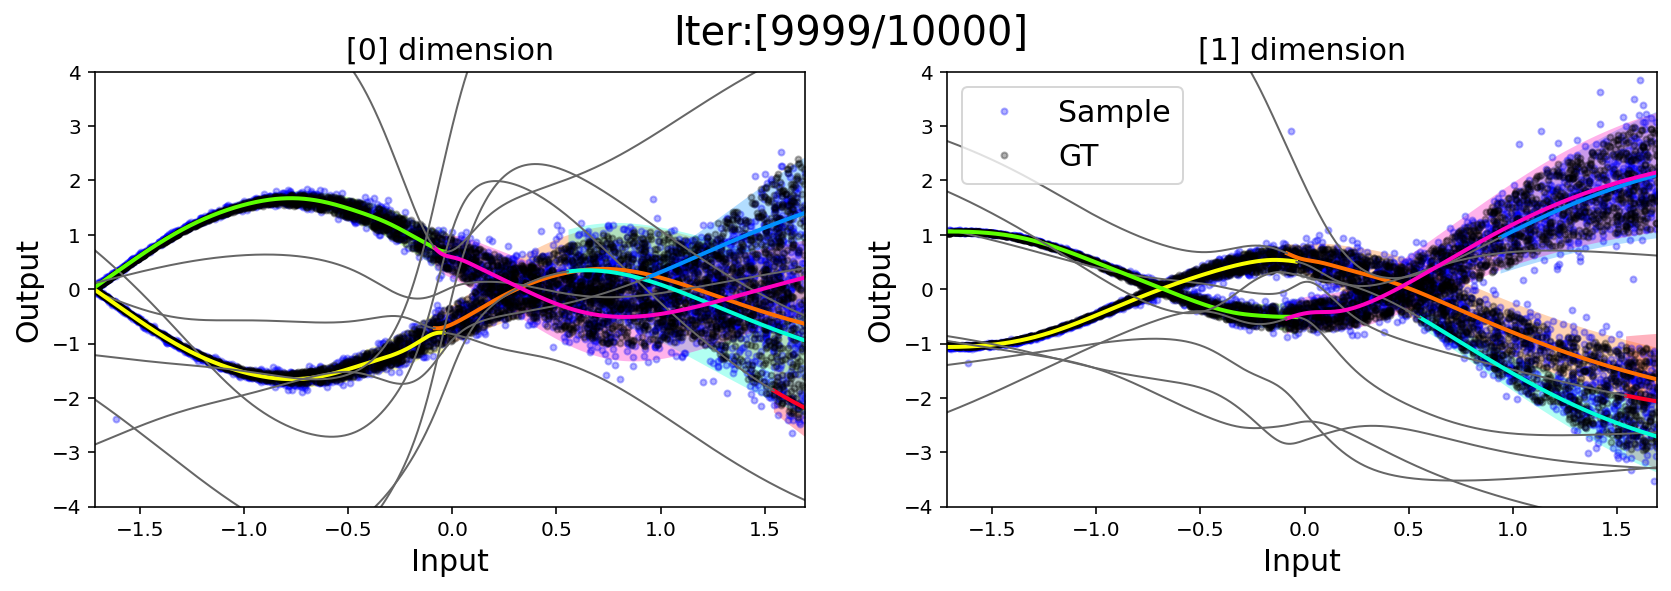

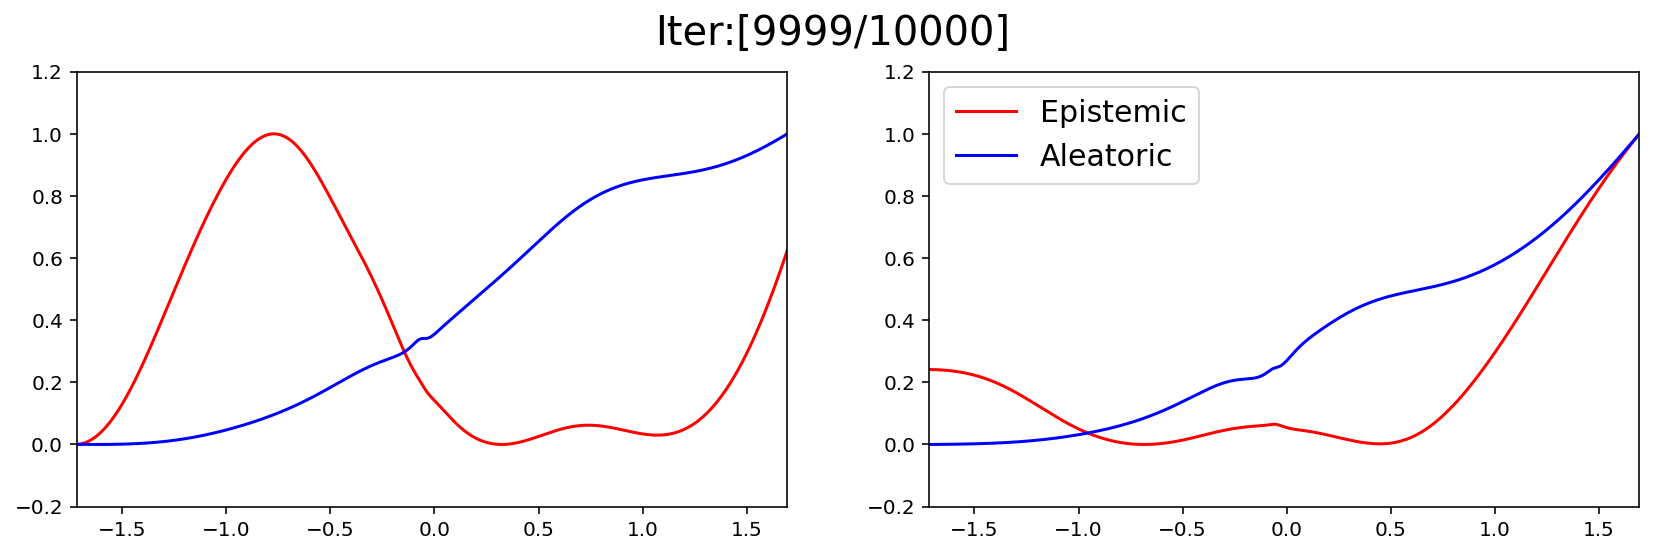

In [9]:
debug_plot(MDN,x_torch,y_torch,x_train_nzd,y_train_nzd)